In [1]:
import os

# Go up one level from notebooks/ to project root
os.chdir("..")
print("Current working dir:", os.getcwd())

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'
device = 'cpu'

Current working dir: /Users/ipeaz/Documents/GitHub/HackathonEBM


# Debiasing in toy examples

## Overview

This notebook demonstrates how to debias corrupted data distributions using EBMs. Here's our approach:

1. **Generate biased data**: We start with a 2D Mixture of Gaussians (MoG) dataset where the true mixture weights are corrupted, leading to a biased training dataset.

2. **Train VAE on biased data**: We train a Variational Autoencoder (VAE) on this corrupted data, resulting in a learned distribution p*(x) that differs from the true distribution p(x).

3. **Debias with EBM**: We use an Energy-Based Model to "tilt" the biased distribution p*(x) using only a few samples from the true distribution, effectively correcting the bias.

This serves as a toy example for understanding how EBMs can be used to correct distributional biases in real-world scenarios.

## 1. Train a VAE on a biased dataset

In [2]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="../configs/"):
    config = compose(config_name="mog_vae_biased") 
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

print(OmegaConf.to_yaml(config.model))

/var/folders/p5/xh_l00hj0xs35gf0ndj424wm0000gq/T/ipykernel_18813/856258733.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):


_target_: src.models.VAE
_recursive_: false
K: 1
latent_dim: 1
likelihood:
  _target_: src.likelihoods.GaussianLikelihood
  min_logvar: -3.0
  learn_var: true
encoder:
  _target_: src.layers.MLP
  input_dim: 2
  hidden_dims:
  - 32
  - 32
  - 32
  output_dim: 2
  activation: relu
decoder:
  _target_: src.layers.MLP
  input_dim: 1
  hidden_dims:
  - 32
  - 32
  - 32
  output_dim: 4
  activation: relu



/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mog_vae_biased': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

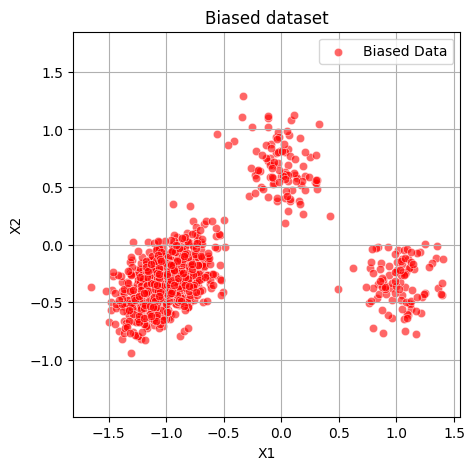

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.utils import get_data_loaders

# Loader for biased dataset
loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]


data = loaders[0].dataset.data.squeeze()  # Remove extra dimensions

# Plot the two datasets
plt.figure(figsize=(5,5))
sns.scatterplot(x=data[:, 0], y=data[:, 1], color='red', alpha=0.6)

plt.title('Biased dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid()

plt.legend(['Biased Data'])
plt.show()

In [4]:
from hydra.utils import instantiate
from pytorch_lightning import Trainer
from src.utils import get_wandb_logger
from pytorch_lightning.callbacks import ModelCheckpoint

# Logger
wandb_logger, vae_run_dir = get_wandb_logger(config, "mog_vae_biased")


# Add ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(vae_run_dir, "checkpoints"),
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=1,
    save_last=True,
    monitor="val_loss",
    mode="min",
)
callbacks = [checkpoint_callback]

# Initialize model
vae = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=vae_run_dir,
    gradient_clip_val=config.train.gradient_clip_val,
    callbacks=callbacks,
    accelerator=device
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [5]:
trainer.fit(vae, loaders[0])

/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
wandb: Currently logged in as: ipeis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: ipeis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | MLP                | 2.3 K  | train
1 | decoder    | MLP                | 2.3 K  | train
2 | likelihood | GaussianLikelihood | 0      | train
----------------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller tha

Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s, v_num=ombp, train/loss=2.310]         

/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:467: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train/loss', 'train/log_px', 'train/kl', 'train/elbo', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 1999: 100%|██████████| 8/8 [00:00<00:00, 254.02it/s, v_num=ombp, train/loss=0.508] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 8/8 [00:00<00:00, 220.04it/s, v_num=ombp, train/loss=0.508]



In [6]:
samples = vae.sample(1000).detach().squeeze().cpu().numpy() # (1000, num_steps, 2)

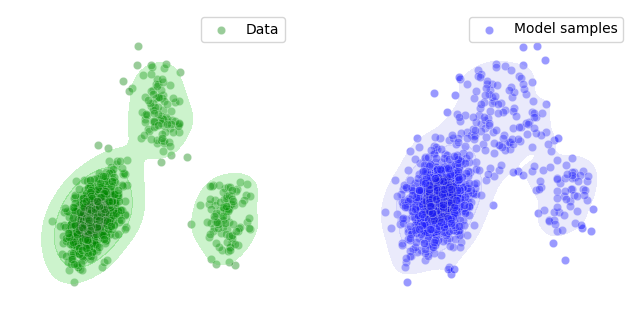

In [7]:
def plot_kde_contours(data, samples):
    # Plot subplots with kde contours of the training data and VAE samples
    f, ax = plt.subplots(1,2, figsize=(8,4))

    sns.scatterplot(x=data[:, 0], y=data[:, 1], label='Data', color='green', alpha=0.4, ax=ax[0])
    sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=5, color='green', label='True density', fill=True, alpha=0.3, ax=ax[0])

    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], label='Model samples', color='blue', alpha=0.4, ax=ax[1])
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], levels=5, color='blue', label='Model density', fill=True, alpha=0.3, ax=ax[1])

    # Legend
    ax[0].axis('off'); ax[1].axis('off');

plot_kde_contours(data, samples)

## 2. Debiasing in data space with EBM

In [12]:
with initialize(config_path="../configs/"):
    config = compose(config_name="mog_ebm_debiasing") 
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

# Use previous VAE as base model
config.model.base_model = os.path.join(vae_run_dir, "checkpoints", "last.ckpt")

print(OmegaConf.to_yaml(config.model))

_target_: src.models.EBMTilting
_recursive_: false
energy_scale: 5.0
wgan_gp_lambda: 0.0
l2_energy_lambda: 0.0001
l2_params_lambda: 1.0e-05
base_model: ./logs/EBM_Hackathon/mog_vae_biased-2025-11-14T11-57-29/checkpoints/last.ckpt
energy_net:
  _target_: src.layers.MLP
  input_dim: 2
  hidden_dims:
  - 32
  - 32
  output_dim: 1
  activation: swish
sampler:
  _target_: src.samplers.SGLD
  input_dim: ${data.dim}
  input_shape: ${data.shape}
  sample_size: ${train.batch_size}
  steps: 50
  step_size: 0.01
  noise_std: 0.5
  clip_grads: true



/var/folders/p5/xh_l00hj0xs35gf0ndj424wm0000gq/T/ipykernel_18813/3188903114.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mog_ebm_debiasing': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


This model will be trained on only 1000 unbiased samples (10% of the biased dataset size):

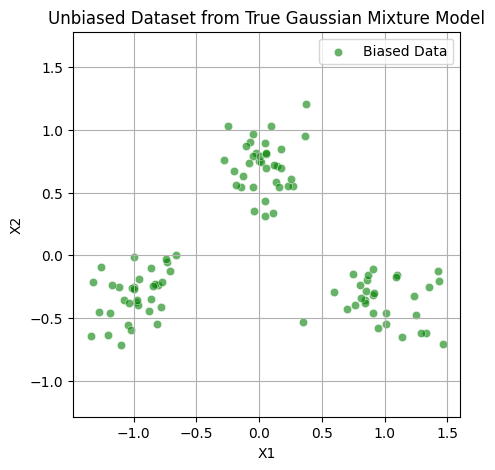

In [13]:
# Loader for biased dataset
loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]

data = loaders[0].dataset.data.squeeze()  # Remove extra dimensions

# Plot the two datasets
plt.figure(figsize=(5,5))
sns.scatterplot(x=data[:, 0], y=data[:, 1], color='green', alpha=0.6)

plt.title('Unbiased Dataset from True Gaussian Mixture Model')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid()

plt.legend(['Biased Data'])
plt.show()

In [14]:
# Logger
wandb_logger, run_dir = get_wandb_logger(config, "mog_ebm_debiasing")

# Initialize model
ebm = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=run_dir,
    gradient_clip_val=config.train.gradient_clip_val,
    accelerator=device
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Restored from ./logs/EBM_Hackathon/mog_vae_biased-2025-11-14T11-57-29/checkpoints/last.ckpt


/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Let's first see how the samples from the biased VAE look like:

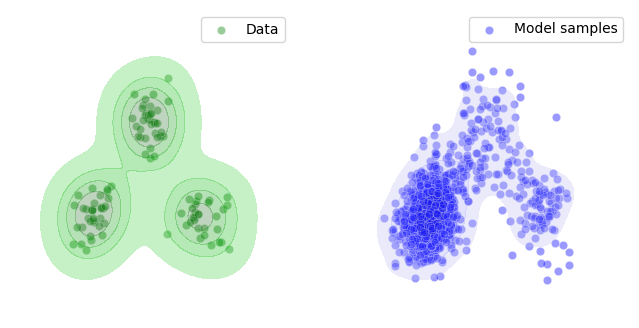

In [15]:
samples = ebm.base_model.sample(1000).detach().squeeze().cpu().numpy() # (1000, num_steps, 2)

def plot_kde_contours(data, samples):
    # Plot subplots with kde contours of the training data and VAE samples
    f, ax = plt.subplots(1,2, figsize=(8,4))

    sns.scatterplot(x=data[:, 0], y=data[:, 1], label='Data', color='green', alpha=0.4, ax=ax[0])
    sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=5, color='green', label='True density', fill=True, alpha=0.3, ax=ax[0])

    # Get axis limits
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()

    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], label='Model samples', color='blue', alpha=0.4, ax=ax[1])
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], levels=5, color='blue', label='Model density', fill=True, alpha=0.3, ax=ax[1])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)

    # Legend
    ax[0].axis('off'); ax[1].axis('off');

plot_kde_contours(data, samples)



In [16]:
trainer.fit(ebm, loaders[0])

/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | energy_net | MLP  | 1.2 K  | train
1 | sampler    | SGLD | 0      | train
2 | base_model | VAE  | 4.6 K  | eval 
--------------------------------------------
1.2 K     Trainable params
4.6 K     Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)
8         Modules in train mode
20        Modules in eval mode
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch

Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s, v_num=ombp, train/loss=-13.0] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s, v_num=ombp, train/loss=-13.0]



In [17]:
samples = ebm.sample(1000, steps=30).detach().squeeze().cpu().numpy() # (1000, num_steps, 2)


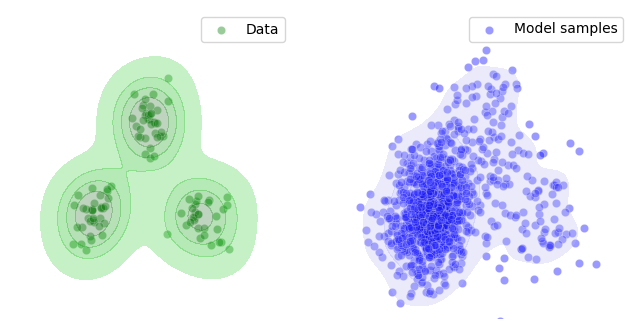

In [18]:
plot_kde_contours(data, samples)

# Diagnosing the EBM

Energy stats for VAE samples: mean=9.971, std=11.472
Energy stats for real data: mean=-4.271, std=14.306
Energy difference (data - vae): -14.242


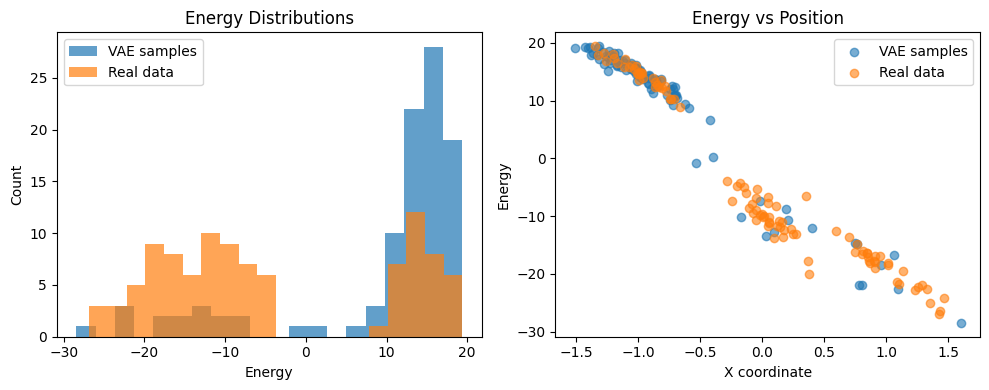

In [20]:
import torch
# Monitor energy values during training to check for instability
# Run this periodically during training

# Sample from VAE (biased initialization)
vae_samples = ebm.base_model.sample(100).detach()

# Compute energies
energies_vae = ebm.energy_net(vae_samples).detach().cpu().numpy().flatten()
energies_data = ebm.energy_net(torch.tensor(data[:100], dtype=torch.float32)).detach().cpu().numpy().flatten()

print(f"Energy stats for VAE samples: mean={energies_vae.mean():.3f}, std={energies_vae.std():.3f}")
print(f"Energy stats for real data: mean={energies_data.mean():.3f}, std={energies_data.std():.3f}")
print(f"Energy difference (data - vae): {energies_data.mean() - energies_vae.mean():.3f}")

# Plot energy distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(energies_vae, alpha=0.7, label='VAE samples', bins=20)
plt.hist(energies_data, alpha=0.7, label='Real data', bins=20)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.legend()
plt.title('Energy Distributions')

plt.subplot(1, 2, 2)
# Scatter plot of energy vs position
plt.scatter(vae_samples[:, 0].cpu(), energies_vae, alpha=0.6, label='VAE samples')
plt.scatter(data[:100, 0], energies_data, alpha=0.6, label='Real data')
plt.xlabel('X coordinate')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy vs Position')
plt.tight_layout()
plt.show()